## TripleTen Code Jam 2023
**Team: Santa's Coders**
- Marco Fernstaedt
- Veronica Steele
- Andrew Kwon

In this project, our team designed a delivery route application where users can select a start location and up to seven destinations. This project applies various methods to solving/estimating a small scale adaptation of the traveling salesman problem, or shortest Hamiltonian cycle.

### Libraries, Packages, Modules

The required libraries are contained in the route.py module, and are as follows:
- pandas (2.1.2)
- random
- math
- itertools
- geopy (2.4.1)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from route import Locations, Route
from mpl_toolkits.basemap import Basemap

### Initializing Data

We'll create a Locations object from the dataset. The Locations object stores the dataset information as a pandas DataFrame and can be retrieved for analysis.

In [2]:
filepath = 'datasets\cities_final.csv'
cities = Locations(filepath)

df_all_cities = cities.get_all_cities()
display(df_all_cities.sample(10))
df_all_cities.info()

,City,State,Population,Latitude,Longitude
35,Kansas City,MO,508090,39.104,-94.583
38,Omaha,NE,486051,41.260,-95.940
5,Philadelphia,PA,1603797,39.952,-75.164
33,Fresno,CA,542107,36.737,-119.789
4,Phoenix,AZ,1608139,33.448,-112.074
41,Long Beach,CA,466742,33.768,-118.192
9,San Jose,CA,1013240,37.336,-121.891
28,Louisville,KY,633045,38.257,-85.757
42,Virginia Beach,VA,459470,36.845,-75.974
24,Portland,OR,652503,45.519,-122.679


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        48 non-null     object 
 1   State       48 non-null     object 
 2   Population  48 non-null     int64  
 3   Latitude    48 non-null     float64
 4   Longitude   48 non-null     float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.0+ KB


The original dataset was dervied from the 2020 US census report. For our project, we filtered out cities with populations less than 400,000 in order to provide users a simplified list of destination cities from which to create a route. The resulting dataset has 48 cities with their associated locations in latitude-longitude, popluation, and state. To demonstrate the route algorithms, we'll pick an arbitrary start city and randomly select seven destination cities.

In [3]:
dest_cities = cities.get_all_cities().sample(10, random_state=42)['City'].to_list()
home = dest_cities.pop()
print(f'Home: {home}')
print(f'Cities: {dest_cities}')

Home: Las Vegas
Cities: ['Memphis', 'Raleigh', 'Detroit', 'Miami', 'Portland', 'Atlanta', 'Fort Worth', 'Washington', 'Phoenix']


To facilitate the plotting of each route, we'll retrieve the coordinates for each city from the Locations object. Given the start city and destination nodes, we can generate graph edges, edge weights, and start-arrival coordinates for each city pair. Additionally, we can initialize a Route object to begin calculating various routes and their associated costs.

In [4]:
edges, weights, coords = cities.create_map(home, dest_cities)
route = Route(home, dest_cities, edges, weights)

### Route Algorithms

To illustrate optimization improvements, we'll compare the following search path algorithms:  
- Random path (baseline)
- Greedy
- K-optimal Tours (Heuristic)
- Brute Force

The cost of each tour is the total great circle distance in nautical miles. We'll store the routes and their calculations for comparative analysis in the final portion of this notebook.

In [5]:
algo_names = ['Random', 'Greedy', 'Exact', 'Heuristic']
all_rtes = []
all_dists = []
all_times = []

**Random Route**

As the name implies, the random algorithm selects each destination randomly along the route.

In [6]:
rand_rte, rand_cost, rand_time = route.get_random_rte()

all_rtes.append(rand_rte)
all_dists.append(rand_cost)
all_times.append(rand_time)

print(f'Random Route: {rand_rte}')
print(f'Total Distance: {"{:.1f}".format(rand_cost)} nm')
print(f'Calculation Time: {rand_time} ns')

Random Route: ['Las Vegas', 'Memphis', 'Raleigh', 'Detroit', 'Fort Worth', 'Portland', 'Miami', 'Atlanta', 'Phoenix', 'Washington', 'Las Vegas']
Total Distance: 12295.6 nm
Calculation Time: 0 ns


**Greedy Route**

The greedy algorithm chooses the next closest city for each destination along the route, starting and ending with the home city.

In [7]:
greedy_rte, greedy_cost, greedy_time = route.get_greedy_rte()

all_rtes.append(greedy_rte)
all_dists.append(greedy_cost)
all_times.append(greedy_time)

print(f'Greedy Route: {greedy_rte}')
print(f'Total Distance: {"{:.1f}".format(greedy_cost)} nm')
print(f'Calculation Time: {greedy_time} ns')

Greedy Route: ['Las Vegas', 'Phoenix', 'Fort Worth', 'Memphis', 'Atlanta', 'Raleigh', 'Washington', 'Detroit', 'Miami', 'Portland', 'Las Vegas']
Total Distance: 6511.9 nm
Calculation Time: 0 ns


**Shortest Route**

The shortest route (or exact route) is a brute force approach that tours every Hamiltonian cycle permutation, starting and ending at the home city. The algorithm returns the minimum cost route (i.e. shortest circuit).

In [8]:
exact_rte, exact_cost, exact_time = route.get_exact_rte()

all_rtes.append(exact_rte)
all_dists.append(exact_cost)
all_times.append(exact_time)

print(f'Shortest Route: {exact_rte}')
print(f'Total Distance: {"{:.1f}".format(exact_cost)} nm')
print(f'Calculation Time: {exact_time} ns')

Shortest Route: ['Las Vegas', 'Portland', 'Detroit', 'Washington', 'Raleigh', 'Miami', 'Atlanta', 'Memphis', 'Fort Worth', 'Phoenix', 'Las Vegas']
Total Distance: 5688.1 nm
Calculation Time: 781250000 ns


**Heuristic Route**

The final optimization algorithm incorporates a k-optimal tour (2 edges) heuristic approximation for the shortest path. The starting route that the optimization algorithm attemps to improve is a randomly generated route; it iterates between node pairs and swaps their edges in an attempt to remove overlapping paths along the Hamiltonian cycle. The algorithm stops when the route can no longer be improved (i.e. no longer can lower the local minimum).

In [9]:
opt_rte, opt_cost, opt_time = route.get_2opt_rte(rand_rte)

all_rtes.append(opt_rte)
all_dists.append(opt_cost)
all_times.append(opt_time)

print(f'Heuristic Route: {opt_rte}')
print(f'Total Distance: {"{:.1f}".format(opt_cost)} nm')
print(f'Calculation Time: {opt_time} ns')

Heuristic Route: ['Las Vegas', 'Portland', 'Detroit', 'Washington', 'Raleigh', 'Miami', 'Atlanta', 'Memphis', 'Fort Worth', 'Phoenix', 'Las Vegas']
Total Distance: 5688.1 nm
Calculation Time: 0 ns


### Route Visualization and EDA

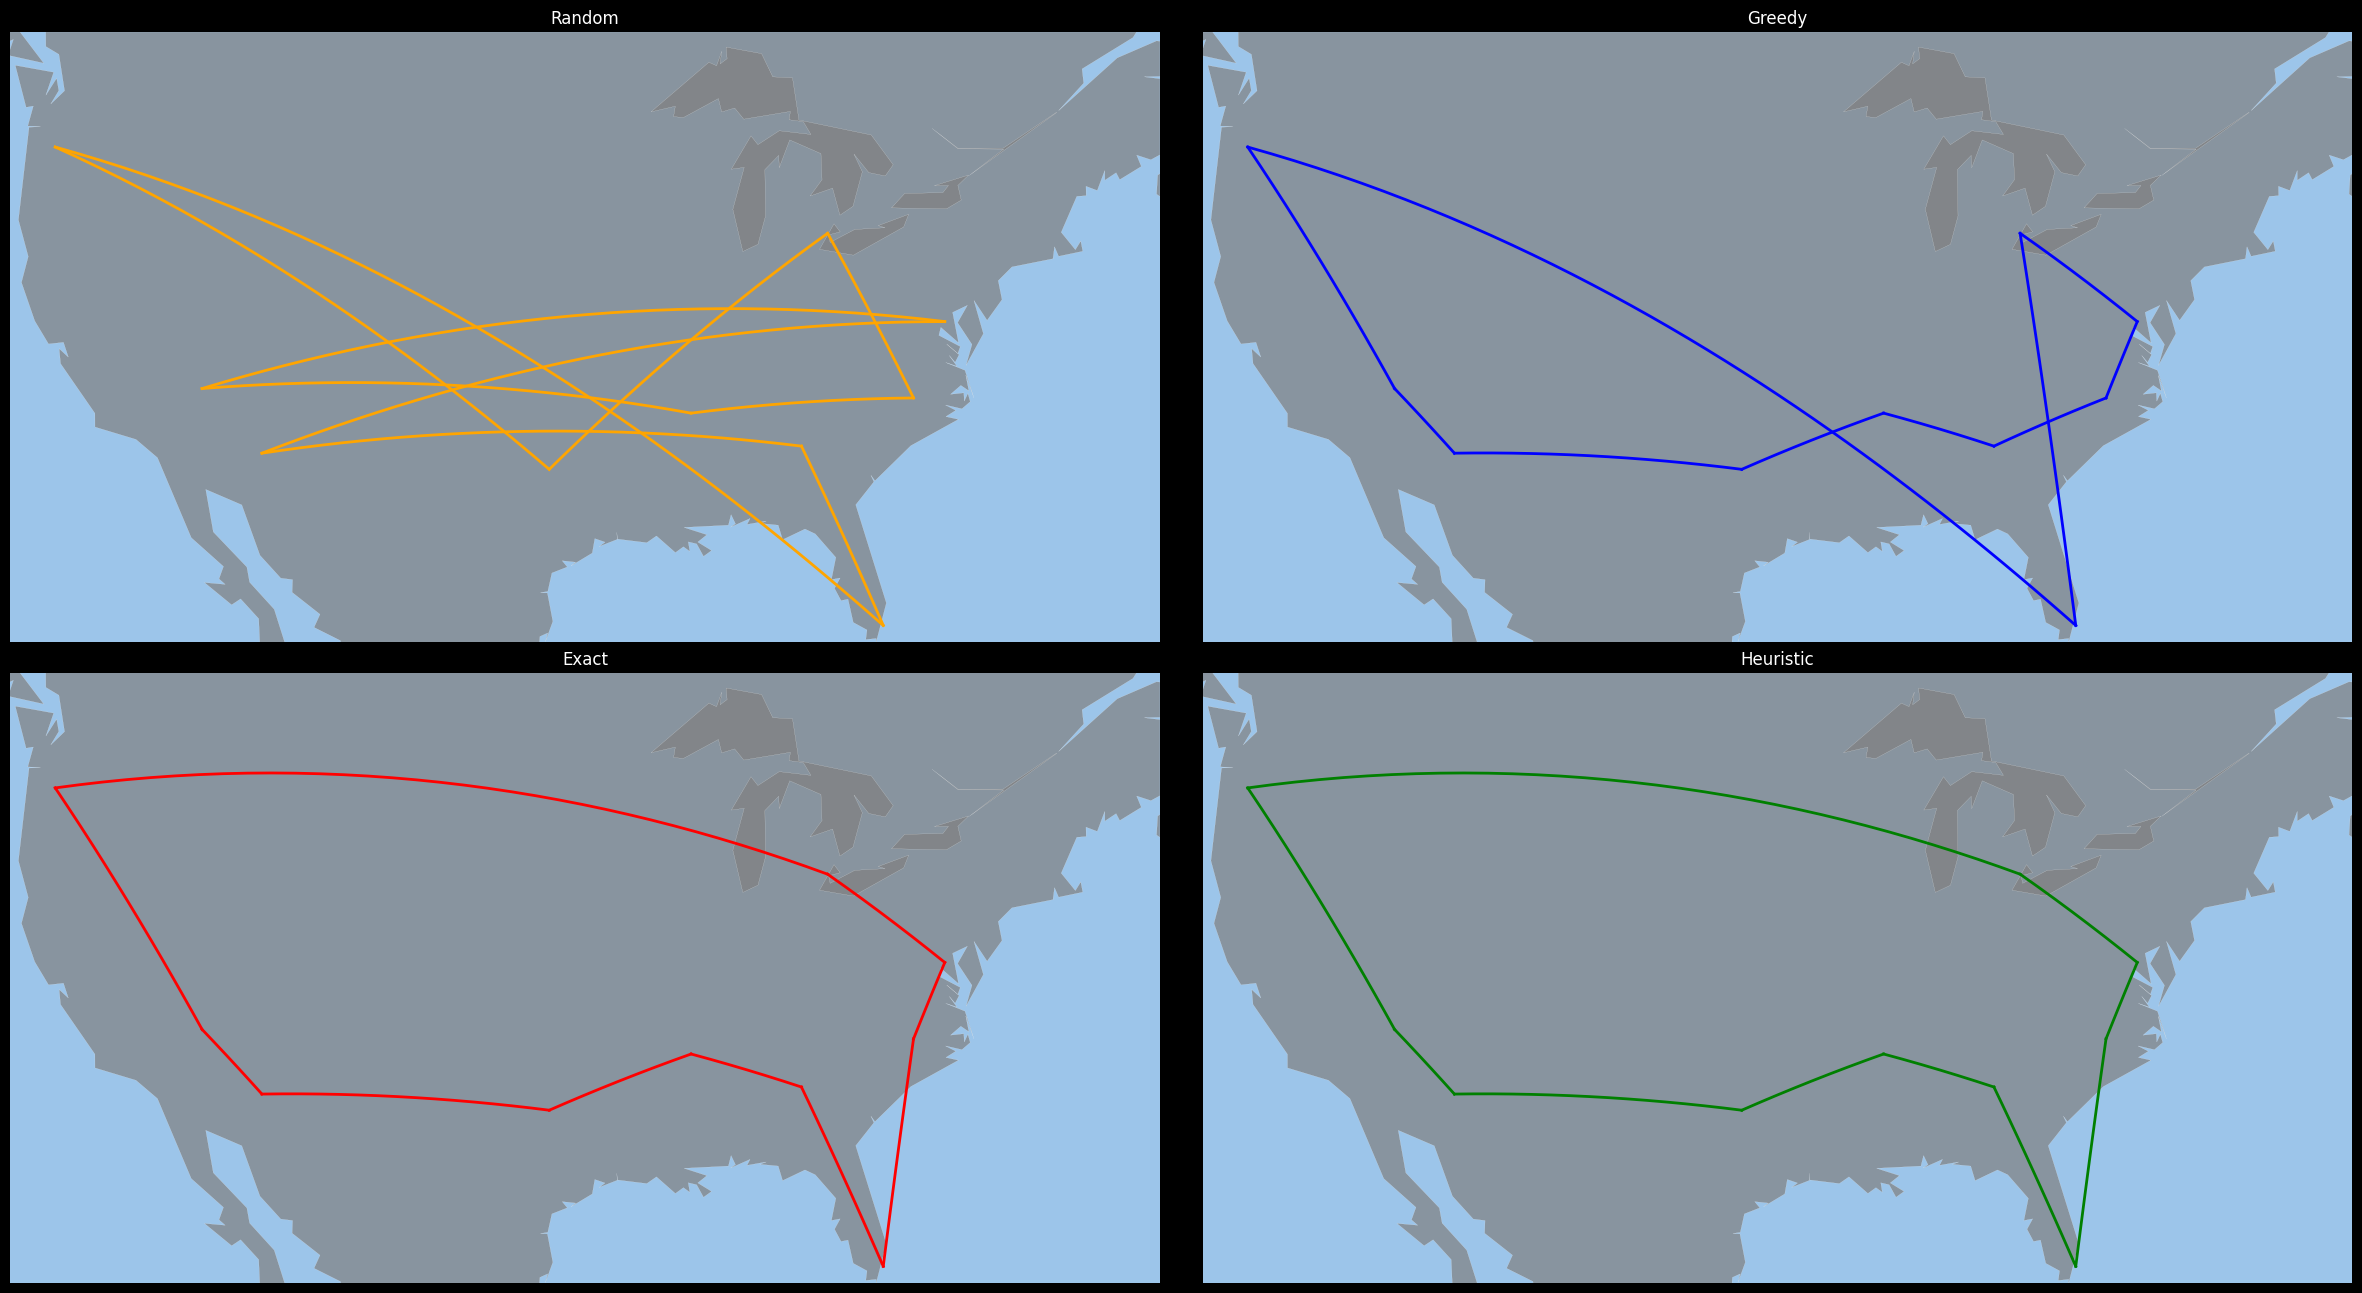

In [10]:
colors = ['orange', 'blue', 'red', 'green']
plt.style.use('dark_background')
fig, axes = plt.subplots(2, 2, figsize=(24, 13))

idx = 0
for i in range(2):
    for j in range(2):
        axes[i][j].set_title(algo_names[idx])
        m=Basemap(llcrnrlon=-125, llcrnrlat=25, urcrnrlon=-66, urcrnrlat=49.5, projection='merc', ax=axes[i][j])
        m.drawmapboundary(fill_color='#9CC5EA', linewidth=0)
        m.fillcontinents(color='grey', alpha=0.7, lake_color='grey')
        m.drawcoastlines(linewidth=0.1, color="white")

        rte = all_rtes[idx]
        startlat, startlon = coords[rte[0]]
        for k in range(1, len(rte)):
            arrlat, arrlon = coords[rte[k]]
            m.drawgreatcircle(startlon, startlat, arrlon, arrlat, linewidth=2, color=colors[idx], ax=axes[i][j])
            startlat = arrlat
            startlon = arrlon
        idx += 1

fig.tight_layout()
plt.show()

# Remove comment to export plot as .png image
# plt.savefig('route_plot.png')

In [11]:
diff_dist = [(x - exact_cost)/exact_cost for x in all_dists]

index = ['Distance', '% Change', 'Times']
data = [all_dists, diff_dist, all_times]
pd.options.display.float_format = '{:,.2f}'.format
df_results = pd.DataFrame(data = data, index=index, columns=algo_names)

display(df_results)

,Random,Greedy,Exact,Heuristic
Distance,"12,295.59","6,511.94","5,688.09","5,688.09"
% Change,1.16,0.14,0.00,0.00
Times,0.00,0.00,"781,250,000.00",0.00


Barring a lucky guess, it is intuitive that a randomly generated route would have the worst overall performance; that is, it has the worst tour cost associated with its route. The greedy route showed improved performance with a 14% increase in distance from the exact shortest path. The heuristic approach was able to find the shortest path. It is important to note this approximation method DOES NOT guarantee the exact shortest path, and its optimization potential is largely dependent on the initial route. That said, its performance should generally beat other optimization methods such as a greedy search and its runtime is significantly faster than a brute force solution, especially as the number of nodes increase.